# For Jax Cosmo

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.append('../reference/jax-cosmo/jax_cosmo-master/')

Import other libraries.

In [56]:
import jax.numpy as jnp
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sacc
from jax import grad, jit, vmap, jacfwd
from jax import random
import jax_cosmo as jc
import pyccl as ccl

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 15
save_plots = False
key = random.PRNGKey(0)

In [4]:
saccfile = sacc.Sacc.load_fits('../data/cls_DESY1.fits')

In [5]:
tracers_names = list(saccfile.tracers.keys())
nbin_gc = sum(['DESgc__' in tracers_names[i] for i in range(len(tracers_names))])
nbin_wl = sum(['DESwl__' in tracers_names[i] for i in range(len(tracers_names))])

# Redshift Distribution (Galaxy Clustering)

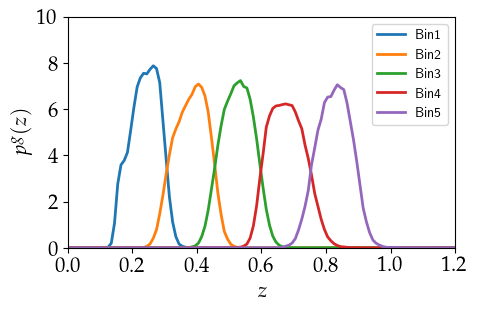

In [6]:
plt.figure(figsize=(5,3))
for i in range(nbin_gc):
    name = f'DESgc__{i}'
    distribution = saccfile.tracers[name]
    plt.plot(distribution.z, distribution.nz, lw = 2, label=f'Bin{i+1}')
plt.ylabel(r'$p^{g}(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0, 10)
plt.xlim(0, 1.2)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':fontSize-5})
if save_plots:
    plt.savefig('../plots/carlos_nz_gc.pdf', bbox_inches = 'tight')
plt.show()

# Using Jax Cosmo

If we want to use JAX cosmo to get the redshift distributions. 

In [7]:
jax_nz_gc = list()
for i in range(nbin_gc):
    name = f'DESgc__{i}'
    distribution = saccfile.tracers[name]
    zmax = max(distribution.z)
    jaxred = jc.redshift.custom_nz(distribution.z.astype('float32'),distribution.nz.astype('float32'), zmax = zmax)
    jax_nz_gc.append(jaxred)

In [8]:
redshifts = distribution.z.astype('float32')

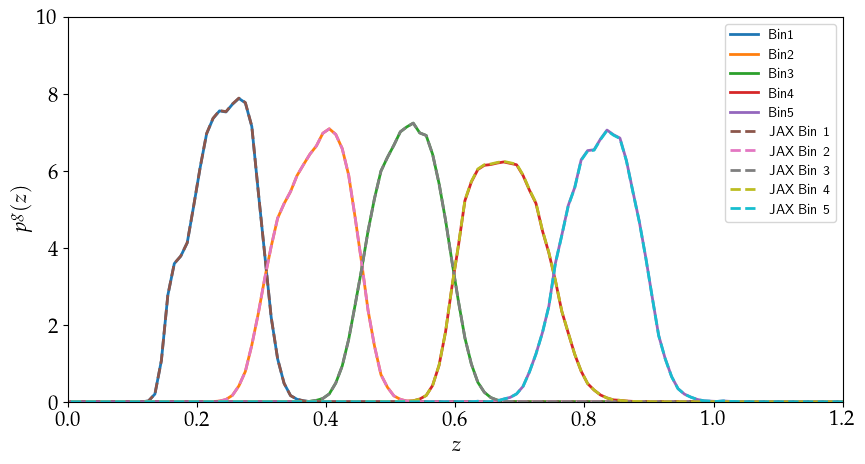

In [9]:
plt.figure(figsize=(10,5))
for i in range(nbin_gc):
    name = f'DESgc__{i}'
    distribution = saccfile.tracers[name]
    plt.plot(distribution.z, distribution.nz, lw = 2, label=f'Bin{i+1}')
for i in range(nbin_gc):
    plt.plot(redshifts, jax_nz_gc[i](redshifts), lw = 2, label = f'JAX Bin {i+1}', linestyle = '--')
plt.ylabel(r'$p^{g}(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0, 10)
plt.xlim(0, 1.2)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':fontSize-5})
if save_plots:
    plt.savefig('../plots/carlos_nz_gc_jax.pdf', bbox_inches = 'tight')
plt.show()

# Redshift Distribution (Weak Lensing)

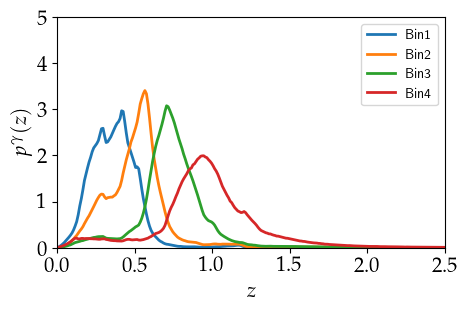

In [10]:
plt.figure(figsize=(5,3))
for i in range(nbin_wl):
    name = f'DESwl__{i}'
    distribution = saccfile.tracers[name]
    plt.plot(distribution.z, distribution.nz, lw = 2, label=f'Bin{i+1}')
plt.ylabel(r'$p^{\gamma}(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0, 5)
plt.xlim(0, 2.5)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':fontSize-5})
if save_plots:
    plt.savefig('../plots/carlos_nz_wl.pdf', bbox_inches = 'tight')
plt.show()

# Using JAX Cosmo

In [11]:
jax_nz_wl = list()
for i in range(nbin_wl):
    name = f'DESwl__{i}'
    distribution = saccfile.tracers[name]
    zmax = max(distribution.z)
    jaxred = jc.redshift.custom_nz(distribution.z.astype('float32'),distribution.nz.astype('float32'), zmax = zmax)
    jax_nz_wl.append(jaxred)

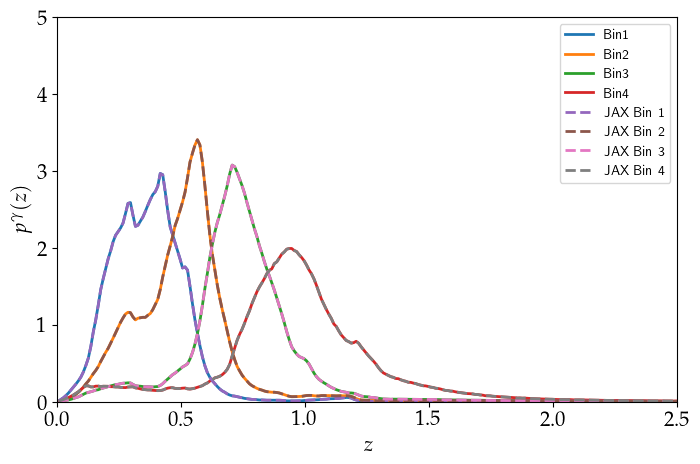

In [12]:
plt.figure(figsize=(8,5))
for i in range(nbin_wl):
    name = f'DESwl__{i}'
    distribution = saccfile.tracers[name]
    plt.plot(distribution.z, distribution.nz, lw = 2, label=f'Bin{i+1}')
for i in range(nbin_wl):
    plt.plot(redshifts, jax_nz_wl[i](redshifts), lw = 2, label = f'JAX Bin {i+1}', linestyle = '--')
plt.ylabel(r'$p^{\gamma}(z)$', fontsize = fontSize)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0, 5)
plt.xlim(0, 2.5)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':fontSize-5})
if save_plots:
    plt.savefig('../plots/carlos_nz_wl_jax.pdf', bbox_inches = 'tight')
plt.show()

# Scale Cuts

In [13]:
# Now impose scale cuts for galaxy clustering and galaxy-galaxy lensing
# Maximum multipole for the 5 different galaxy redshift bins
# lmaxs = [145, 225, 298, 371, 435]

In [14]:
def calculate_lmax_gc(sfile, kmax):
    nbin_gc = sum(['DESgc__' in tracers_names[i] for i in range(len(tracers_names))])
    vanillacosmo = jc.Planck15() # ccl.CosmologyVanillaLCDM()
    lmaxs = list()
    
    for i in range(nbin_gc):
        tracer = sfile.tracers[f'DESgc__{i}']
        zmid = jnp.average(jnp.asarray(tracer.z), weights=jnp.asarray(tracer.nz))
        chi = jc.background.radial_comoving_distance(vanillacosmo, 1./(1. + zmid))
        minmax = jnp.concatenate([10.*jnp.ones(1), kmax * chi - 0.5], dtype = int)
        lmax = jnp.max(minmax)
        lmaxs.append(lmax)
    return lmaxs

In [15]:
def scale_cuts(sfile, kmax = 0.15, lmax_wl = 2000):
    # First we remove all B-modes
    sfile.remove_selection(data_type='cl_bb')
    sfile.remove_selection(data_type='cl_be')
    sfile.remove_selection(data_type='cl_eb')
    sfile.remove_selection(data_type='cl_0b')

    tracers_names = list(sfile.tracers.keys())
    nbin_gc = sum(['DESgc__' in tracers_names[i] for i in range(len(tracers_names))])
    nbin_wl = sum(['DESwl__' in tracers_names[i] for i in range(len(tracers_names))])
    lmaxs_gc = calculate_lmax_gc(sfile, kmax)
    
    for i, lmax in enumerate(lmaxs_gc):
        print(f'Maximum ell is {lmax}')
        tname_1 = f'DESgc__{i}'
        
        # Remove from galaxy clustering
        sfile.remove_selection(data_type='cl_00', tracers=(tname_1, tname_1), ell__gt=lmax)
        
        # Remove from galaxy-galaxy lensing
        for j in range(nbin_wl):
            tname_2 = f'DESwl__{j}'
            sfile.remove_selection(data_type='cl_0e', tracers=(tname_1, tname_2), ell__gt=lmax)
    
    # apply scale cut for weak lensing 
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
            tname_1 = f'DESwl__{i}'
            tname_2 = f'DESwl__{j}'
            sfile.remove_selection(data_type='cl_ee', tracers=(tname_1, tname_2), ell__gt=lmax_wl)
            
    return sfile, lmaxs_gc

In [16]:
saccfile_cut, lmaxs_gc = scale_cuts(saccfile, kmax = 0.15, lmax_wl = 2000)

Maximum ell is 101
Maximum ell is 155
Maximum ell is 206
Maximum ell is 255
Maximum ell is 298


# Bandwindow

In [17]:
def interpolate(ellvalues, clvalues, newells):
    ellvalues_log = jnp.log(ellvalues)
    clvalues_log = jnp.log(clvalues)
    newells_log = jnp.log(newells)
    interpolation = jnp.interp(newells_log, ellvalues_log, clvalues_log)
    interp_final = jnp.exp(interpolation)
    return interp_final

def get_data_type(tracer_combination):
    if 'gc' in tracer_combination[0] and 'gc' in tracer_combination[1]:
        dtype = 'cl_00'
    elif 'gc' in tracer_combination[0] and 'wl' in tracer_combination[1]:
        dtype = 'cl_0e'
    elif 'wl' in tracer_combination[0] and 'wl' in tracer_combination[1]:
        dtype = 'cl_ee'
    return dtype

def get_ells_bandwindow(sfile, tracer_name_1, tracer_name_2, ellmax = 3000):
    
    dtype = get_data_type((tracer_name_1, tracer_name_2))    
    idx = sfile.indices(data_type=dtype, tracers=(tracer_name_1, tracer_name_2))
    window = sfile.get_bandpower_windows(idx)
    fine_ells = window.values
    indices = (fine_ells >= 2) & (fine_ells <= ellmax)
    fine_ells = jnp.asarray(fine_ells[indices], dtype = jnp.float32)
    bandwindow = jnp.asarray(window.weight[indices])
    return fine_ells, bandwindow

def extract_bandwindow(sfile, ellmax = 3000):
    tracers_names = list(sfile.tracers.keys())
    nbin_gc = sum(['DESgc__' in tracers_names[i] for i in range(len(tracers_names))])
    nbin_wl = sum(['DESwl__' in tracers_names[i] for i in range(len(tracers_names))])
    record = dict()
    
    # galaxy-galaxy 
    for i in range(nbin_gc):
        tracer_name = f'DESgc__{i}'
        key = f'{tracer_name},{tracer_name}'
        ells, bandwindow = get_ells_bandwindow(sfile, tracer_name, tracer_name, ellmax)
        record[key] = {'ells': ells, 'bandwindow': bandwindow}

    # galaxy-shear
    for i in range(nbin_gc):
        for j in range(nbin_wl):
            tracer_name_1 = f'DESgc__{i}'
            tracer_name_2 = f'DESwl__{j}'
            key = f'{tracer_name_1},{tracer_name_2}'
            ells, bandwindow = get_ells_bandwindow(sfile, tracer_name_1, tracer_name_2, ellmax)
            record[key] = {'ells': ells, 'bandwindow': bandwindow}
            
    # shear-shear
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
            tracer_name_1 = f'DESwl__{i}'
            tracer_name_2 = f'DESwl__{j}'
            key = f'{tracer_name_1},{tracer_name_2}'
            ells, bandwindow = get_ells_bandwindow(sfile, tracer_name_1, tracer_name_2, ellmax)
            record[key] = {'ells': ells, 'bandwindow': bandwindow}

    return record

In [18]:
record_band = extract_bandwindow(saccfile_cut, ellmax = 3000)

# Data - Galaxy Clustering 

In [19]:
def plot_data_gc(sfile, lmaxs_gc, xlabel, ylabel, ell_grid = None, theory = None, nx = 5, ylims = (1E-6, 5E-4), fontsize = 12, fname = 'data_galaxy_clustering'):

    f, ax = plt.subplots(1, nx, sharex=True, sharey = True, figsize = (15, 3))

    for counter in range(nx):

        tracername = f'DESgc__{counter}'
        ell, c_ell, covariance, indices = sfile.get_ell_cl('cl_00', tracername, tracername, return_cov=True, return_ind=True)
        covariance = np.asarray(covariance)
        sigma = np.sqrt(np.diag(covariance))
        labz = f'$p_{counter+1}(z)$'

        ax[counter].errorbar(ell, c_ell, sigma, fmt='bo', ms=2, lw =1)
        if theory is not None:
            ax[counter].plot(ell_grid, theory[counter], lw = 3, c = 'r')
        ax[counter].set_xlabel(xlabel, fontsize=fontsize)
        ax[counter].set_xlim(min(ell)-5, max(ell)+25)
        ax[counter].set_ylim(ylims[0], ylims[1])
        ax[counter].set_xscale("log")
        ax[counter].set_yscale("log")
        ax[counter].tick_params(axis = 'both', labelsize = fontsize, pad=10)
        ax[counter].tick_params(axis='both', which='both', length=0)
        ax[counter].annotate(labz, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=fontsize, horizontalalignment='center')
        if counter==0 :
            ax[counter].set_ylabel(ylabel, fontsize=fontsize)
    plt.subplots_adjust(wspace=0, hspace=0)
    if fname and save_plots:
        plt.savefig(f'../plots/{fname}.pdf', bbox_inches='tight')
    plt.show()

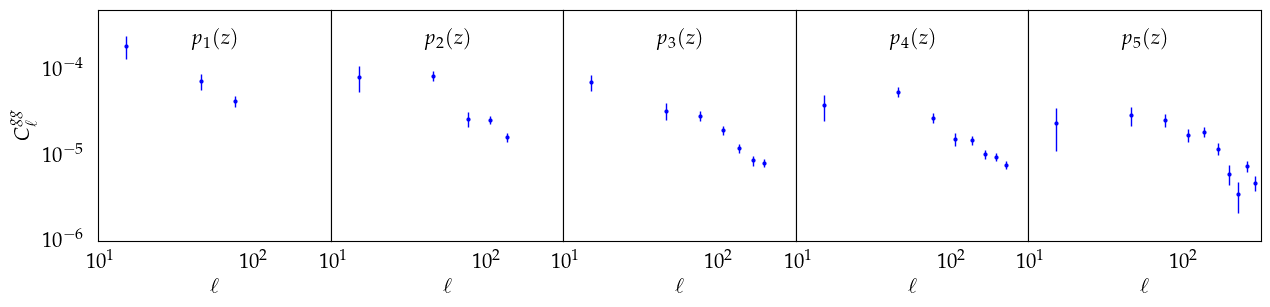

In [20]:
yLabel = r'$C_{\ell}^{gg}$'
xLabel = r'$\ell$'
plot_data_gc(sfile=saccfile_cut, lmaxs_gc=lmaxs_gc, xlabel=xLabel, ylabel=yLabel, fontsize=fontSize, fname = 'carlos_data_gc')

In [21]:
# tracername = f'DESgc__0'
# ell, c_ell, covariance, indices = saccfile_cut.get_ell_cl('cl_00', tracername, tracername, return_cov=True, return_ind=True)
# ell

# Using JAX 
To get the $C_{\ell}^{gg}$. Some functions are borrowed from the JAX cosmo paper. 

In [22]:
def get_params_vec(cosmo, multiplicative, deltaz, ia_params, bias):
    mparam_1, mparam_2, mparam_3, mparam_4 = multiplicative
    dz1, dz2, dz3, dz4 = deltaz
    a_ia_param, eta_param = ia_params
    bias_1, bias_2, bias_3, bias_4, bias_5 = bias
    return jnp.array([
        cosmo.sigma8, cosmo.Omega_c, cosmo.Omega_b, cosmo.h, cosmo.n_s,
        mparam_1, mparam_2, mparam_3, mparam_4,
        dz1, dz2, dz3, dz4,
        a_ia_param, eta_param,
        bias_1, bias_2, bias_3, bias_4, bias_5
    ])
    
def unpack_params_vec(params):
    cosmo = jc.Cosmology(sigma8=params[0], Omega_c=params[1], Omega_b=params[2],
                         h=params[3], n_s=params[4], w0=-1.0, Omega_k=0., wa=0.)
    mparam_1, mparam_2, mparam_3, mparam_4 = params[5:9]
    dz1, dz2, dz3, dz4 = params[9:13]
    a_ia_param, eta_param = params[13], params[14]
    bias = params[15:20]
    return cosmo, [mparam_1, mparam_2, mparam_3, mparam_4], [dz1,dz2,dz3,dz4], [a_ia_param, eta_param], bias

def get_index_pairs(tracer_combinations, tracer1="gc", tracer2="gc"):
    cl_index = list()
    for pair in tracer_combinations:
        if tracer1 in pair[0] and tracer2 in pair[1]:
            cl_index.append((int(pair[0][-1]), int(pair[1][-1])))
    return cl_index

In [23]:
cosmo =  jc.Cosmology(sigma8=0.801, Omega_c=0.2545, Omega_b=0.0485, h=0.682, n_s=0.971, 
                      w0=-1., Omega_k=0., wa=0.)

params = get_params_vec(cosmo, 
                            [0., 0., 0., 0.],
                            [0., 0., 0., 0.],
                            [0.5, 0.],
                            [1.2, 1.4, 1.6, 1.8, 2.0])

cosmo, multiplicative, deltaz, (a_ia_param, eta_param), bias = unpack_params_vec(params) 

In [24]:
nz_wl_sys = [jc.redshift.systematic_shift(nzi, dzi) for nzi, dzi in zip(jax_nz_wl, deltaz)]
gc_biases = [jc.bias.constant_linear_bias(bi) for bi in bias] 
b_ia = jc.bias.des_y1_ia_bias(a_ia_param, eta_param, 0.62)

probes_gc = [jc.probes.NumberCounts(jax_nz_gc, gc_biases)]
probes_wl = [jc.probes.WeakLensing(nz_wl_sys, ia_bias=b_ia, multiplicative_bias=multiplicative)]
probes_gc_wl = probes_gc + probes_wl

In [25]:
tracer_combinations = saccfile_cut.get_tracer_combinations()
tracers = list(saccfile_cut.tracers.keys())

In [26]:
%%capture
ell_grid_gc = jnp.geomspace(2, 300, 50)
idx_pairs_gc = get_index_pairs(tracer_combinations, 'gc', 'gc')
cls_gc = jc.angular_cl.angular_cl(cosmo, ell_grid_gc, probes_gc, index_pairs = idx_pairs_gc)

In [27]:
%%capture
idx_pairs_gc_wl = get_index_pairs(tracer_combinations, 'gc', 'wl')
cls_gc_wl = jc.angular_cl.angular_cl(cosmo, ell_grid_gc, probes_gc_wl, index_pairs = idx_pairs_gc_wl)

In [28]:
%%capture
ell_grid_wl = jnp.geomspace(2, 2000, 50)
idx_pairs_wl = get_index_pairs(tracer_combinations, 'wl', 'wl')
cls_wl = jc.angular_cl.angular_cl(cosmo, ell_grid_wl, probes_wl, index_pairs = idx_pairs_wl)

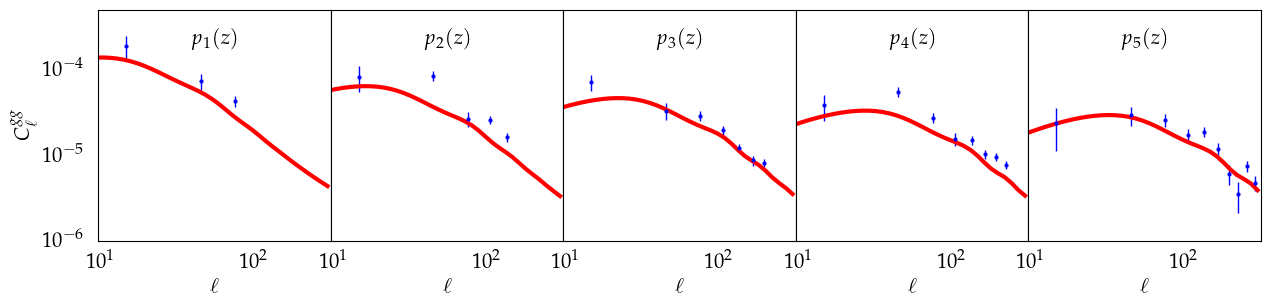

In [29]:
plot_data_gc(saccfile_cut, lmaxs_gc, xLabel, yLabel, ell_grid = ell_grid_gc, theory = cls_gc, fontsize=fontSize, fname = 'carlos_data_gc')

# Data - Galaxy Clustering and Weak Lensing

Number of ell: 3
Number of ell: 3
Number of ell: 3
Number of ell: 3
Number of ell: 5
Number of ell: 5
Number of ell: 5
Number of ell: 5
Number of ell: 7
Number of ell: 7
Number of ell: 7
Number of ell: 7
Number of ell: 8
Number of ell: 8
Number of ell: 8
Number of ell: 8
Number of ell: 10
Number of ell: 10
Number of ell: 10
Number of ell: 10


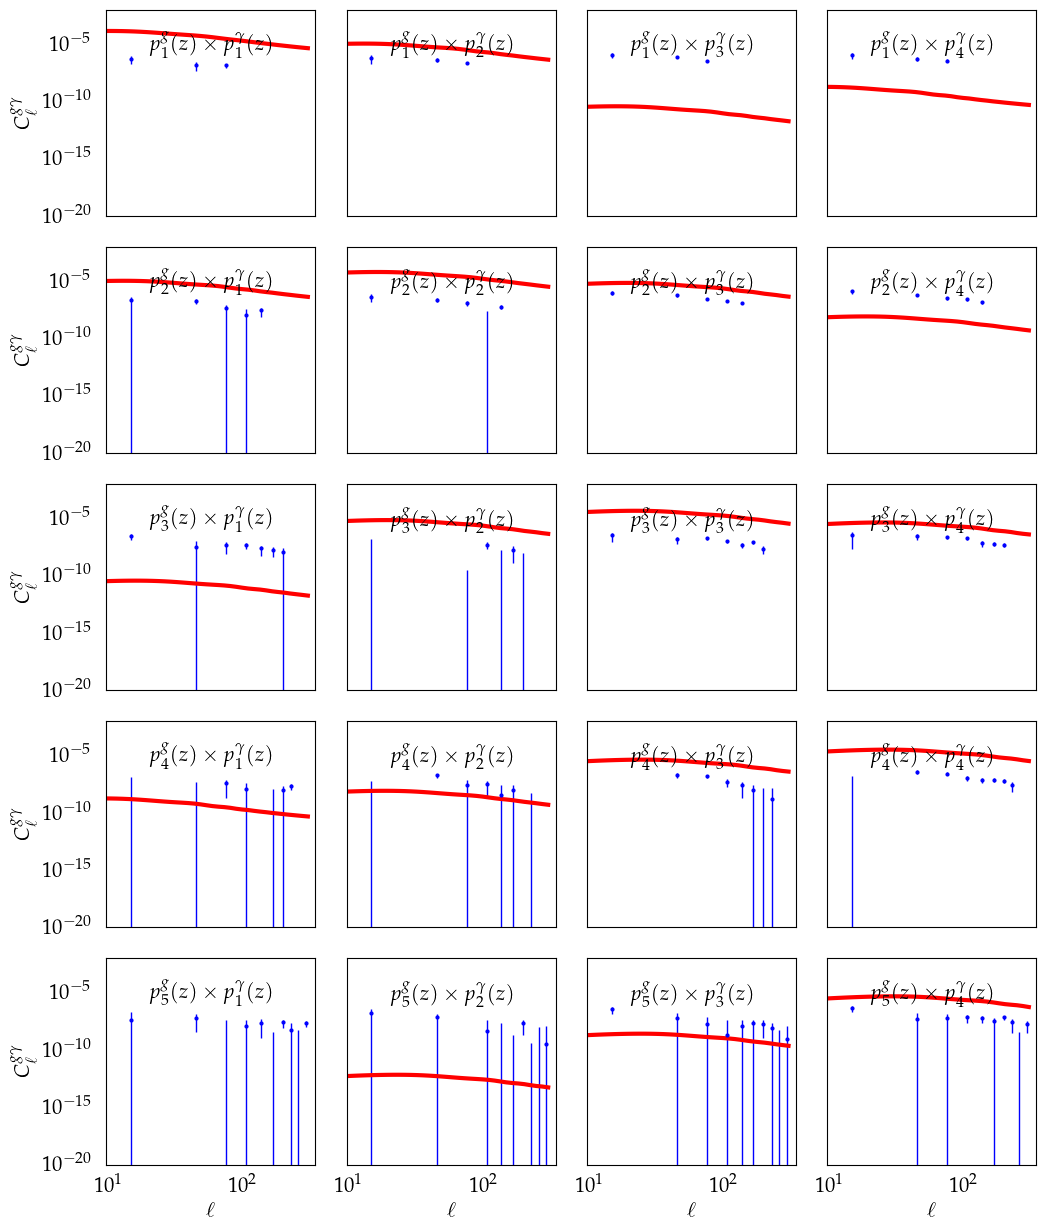

In [30]:
yLabel = r'$C_{\ell}^{g\gamma}$'
xLabel = r'$\ell$'
ylims = [1E-20, 1E-2]
fontsize = fontSize

f, ax = plt.subplots(nbin_gc, nbin_wl, sharex=True, sharey = True, figsize = (12, 15))
counter = 0
for i in range(nbin_gc):
    for j in range(nbin_wl):

        labz = r'$p_{'+str(i+1)+'}^{g}(z)\\times p_{'+str(j+1)+'}^{\gamma}(z)$'
        
        tracername_gc = f'DESgc__{i}'
        tracername_wl = f'DESwl__{j}'
        ell, c_ell, covariance, indices = saccfile_cut.get_ell_cl('cl_0e', tracername_gc, tracername_wl, return_cov=True, return_ind=True)
        covariance = np.asarray(covariance)
        sigma = np.sqrt(np.diag(covariance))
        print(f'Number of ell: {len(ell)}')

        ax[i,j].errorbar(ell, c_ell, sigma, fmt='bo', ms=2, lw =1)
        ax[i,j].plot(ell_grid_gc, cls_gc_wl[counter], lw = 3, c = 'r')
        ax[i,j].set_xlim(min(ell)-5, max(ell)+50)
        ax[i,j].set_ylim(ylims[0], ylims[1])
        ax[i,j].set_xscale("log")
        ax[i,j].set_yscale("log")
        ax[i,j].axhline(0, linestyle='--', c = 'k', lw = 0.5)
        ax[i,j].tick_params(axis = 'both', labelsize = fontsize, pad=10)
        ax[i,j].tick_params(axis='both', which='both', length=0)
        ax[i,j].annotate(labz, xy=(0.5, 0.80), xycoords='axes fraction', fontsize=fontsize, horizontalalignment='center')

        if j==0 :
            ax[i,j].set_ylabel(yLabel, fontsize=fontsize)
        if i==nbin_gc-1:
            ax[i,j].set_xlabel(xLabel, fontsize=fontsize)
            
        counter += 1

f.subplots_adjust(wspace=0.15)
f.subplots_adjust(hspace=0.15)
if save_plots:
    plt.savefig(f'../plots/carlos_data_gc_shear.pdf', bbox_inches='tight')
plt.show()

# Data - Weak Lensing

Number of ells is 25
Number of ells is 25
Number of ells is 25
Number of ells is 25
Number of ells is 25
Number of ells is 25
Number of ells is 25
Number of ells is 25
Number of ells is 25
Number of ells is 25


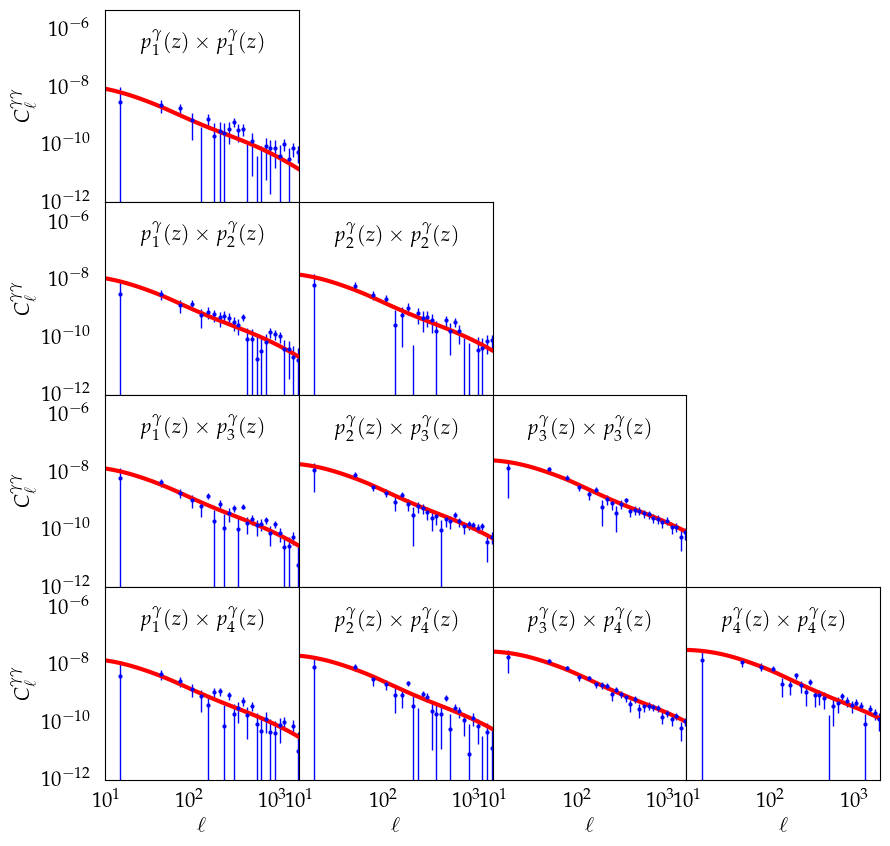

In [31]:
yLabel = r'$C_{\ell}^{\gamma\gamma}$'
xLabel = r'$\ell$'
ylims = [1E-12, 5E-6]
fontsize = fontSize

counter = 0

f, ax = plt.subplots(nbin_wl, nbin_wl, sharex=True, sharey = True, figsize = (10, 10))

for i in range(nbin_wl):
    for j in range(i, nbin_wl):

        labz = r'$p_{'+str(i+1)+'}^{\gamma}(z)\\times p_{'+str(j+1)+'}^{\gamma}(z)$'
        
        tracername_wl_i = f'DESwl__{i}'
        tracername_wl_j = f'DESwl__{j}'
        ell, c_ell, covariance, indices = saccfile.get_ell_cl('cl_ee', tracername_wl_i, tracername_wl_j, return_cov=True, return_ind=True)
        print(f'Number of ells is {len(ell)}')
        sigma = np.sqrt(np.diag(covariance))

        ax[j,i].errorbar(ell, c_ell, sigma, fmt='bo', ms=2, lw =1)
        ax[j,i].plot(ell_grid_wl, cls_wl[counter], lw = 3, c = 'r')
        ax[j,i].set_xlabel(xLabel, fontsize=fontsize)
        ax[j,i].set_xlim(min(ell)-5, max(ell)+50)
        ax[j,i].set_ylim(ylims[0], ylims[1])
        ax[j,i].set_xscale("log")
        ax[j,i].set_yscale("log")
        ax[j,i].axhline(0, linestyle='--', c = 'k', lw = 0.5)
        ax[j,i].tick_params(axis = 'both', labelsize = fontsize, pad=10)
        ax[j,i].tick_params(axis='both', which='both', length=0)
        ax[j,i].annotate(labz, xy=(0.5, 0.80), xycoords='axes fraction', fontsize=fontsize, horizontalalignment='center')

        if i==0 :
            ax[j, i].set_ylabel(yLabel, fontsize=fontsize)

        if j!=i:
            ax[i,j].axis('off')
            
        counter += 1

f.subplots_adjust(wspace=0)
f.subplots_adjust(hspace=0)
if save_plots:
    plt.savefig(f'../plots/carlos_data_shear_shear.pdf', bbox_inches='tight')
plt.show()

# Extract the Data Vector and the Covariance

In [32]:
def extract_data_covariance(saccfile):
    tracers_names = list(saccfile.tracers.keys())
    nbin_gc = sum(['DESgc__' in tracers_names[i] for i in range(len(tracers_names))])
    nbin_wl = sum(['DESwl__' in tracers_names[i] for i in range(len(tracers_names))])
    
    indices = []
    idxpositions = []
    # galaxy-galaxy
    for i in range(nbin_gc):
        tracer_name = f'DESgc__{i}'
        _, _, ind = saccfile.get_ell_cl('cl_00', tracer_name, tracer_name, return_cov=False, return_ind=True)
        indices += list(ind)
    idxpositions.append(len(indices))

    # galaxy-shear
    for i in range(nbin_gc):
        for j in range(nbin_wl):
            tracer_name_1 = f'DESgc__{i}'
            tracer_name_2 = f'DESwl__{j}'
            _, _, ind = saccfile.get_ell_cl('cl_0e', tracer_name_1, tracer_name_2, return_cov=False, return_ind=True)
            indices += list(ind)
            
    idxpositions.append(len(indices))
        
    # shear-shear
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
            tracer_name_1 = f'DESwl__{i}'
            tracer_name_2 = f'DESwl__{j}'
            _, _, ind = saccfile.get_ell_cl('cl_ee', tracer_name_1, tracer_name_2, return_cov=False, return_ind=True)
            indices += list(ind)
    idxpositions.append(len(indices))

    indices = np.array(indices)
    idxpositions = np.hstack([np.zeros(1), np.array(idxpositions)])
    
    covariance = saccfile.covariance.covmat[indices][:, indices]
    data = saccfile.mean[indices]
    return data, covariance, idxpositions

In [33]:
data, datacov, idxpositions = extract_data_covariance(saccfile_cut)

In [34]:
scaledcov = datacov/np.sqrt(np.outer(np.diag(datacov), np.diag(datacov)))
delta = np.diff(idxpositions)
mid = np.array(idxpositions[:-1] + delta/2, dtype = int)

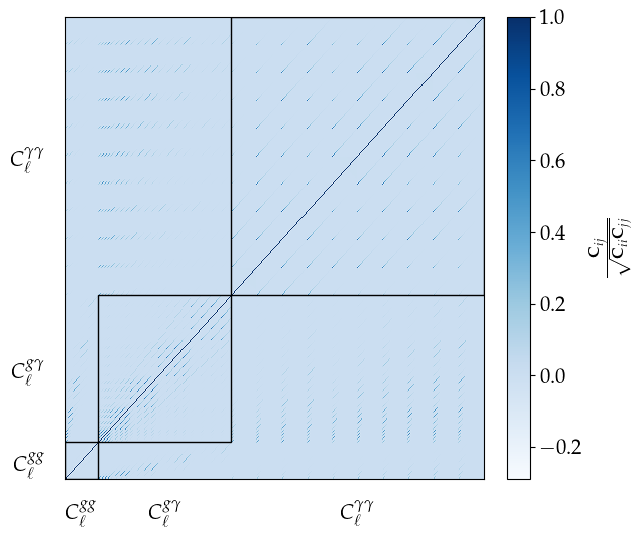

In [35]:
column_labels = [r'$C_{\ell}^{gg}$', r'$C_{\ell}^{g\gamma}$', r'$C_{\ell}^{\gamma\gamma}$']
colormap = plt.cm.Blues

fig, ax = plt.subplots(figsize = (6, 6))

heatmap = ax.pcolor(scaledcov, cmap=colormap, rasterized=True)
cbar = plt.colorbar(heatmap, fraction = 0.05)
cbar.set_label(r'$\frac{\mathbf{C}_{ij}}{\sqrt{\mathbf{C}_{ii}\mathbf{C}_{jj}}}$',size=fontSize)
cbar.ax.tick_params(labelsize=fontSize) 

rect1 = patches.Rectangle((idxpositions[0], idxpositions[0]), delta[0], delta[0], linewidth=1, edgecolor='k', facecolor='none')
rect2 = patches.Rectangle((idxpositions[1], idxpositions[1]), delta[1], delta[1], linewidth=1, edgecolor='k', facecolor='none')
rect3 = patches.Rectangle((idxpositions[2], idxpositions[2]), delta[2], delta[2], linewidth=1, edgecolor='k', facecolor='none')
# rect4 = patches.Rectangle((800, 800), 100, 100, linewidth=1, edgecolor='k', facecolor='none')

# # Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
# ax.add_patch(rect4)

ax.set_xticks(mid, minor=False)
ax.set_yticks(mid, minor=False)

ax.set_xticklabels(column_labels, minor=False, fontsize=fontSize)
ax.set_yticklabels(column_labels, minor=False, fontsize=fontSize)
ax.tick_params(axis=u'both', which=u'both',length=0, pad=15)

if save_plots:
    plt.savefig(f'../plots/carlos_covariance.pdf', bbox_inches='tight')

plt.show()

# Band Window Matrix

$$
C_{\ell, ij}^{\textrm{binned}} = W^{\textrm{T}}_{\ell, ij}C_{\ell,ij}
$$

In [36]:
idx = saccfile.indices(data_type='cl_00', tracers=('DESgc__0', 'DESgc__0'))
window = saccfile.get_bandpower_windows(idx)
ells = window.values
bandwindow = window.weight

In [37]:
get_data_type(tracer_combinations[0])

'cl_00'

In [38]:
get_data_type(tracer_combinations[5])

'cl_0e'

In [39]:
get_data_type(tracer_combinations[-1])

'cl_ee'

# Bandpowers for Galaxy Clustering

In [40]:
def gc_bandpower_calculation(cosmology, galaxybias, nz_gc, record_band, 
                             tracer_combinations, ellmax=3000, nell = 30):
    
    # calculate the coarse power spectra for galaxy clustering
    gc_biases = [jc.bias.constant_linear_bias(bi) for bi in galaxybias] 
    probes_gc = [jc.probes.NumberCounts(nz_gc, gc_biases)]
    ells_coarse = jnp.geomspace(2, ellmax, nell, dtype=jnp.float32)
    idx_pairs_gc = get_index_pairs(tracer_combinations, 'gc', 'gc')
    ps_gc = jc.angular_cl.angular_cl(cosmology, ells_coarse, probes_gc, index_pairs = idx_pairs_gc)
    
    # list to record the band powers
    recordbandpowers = dict()
    nbin_gc = len(nz_gc)
    
    for i in range(nbin_gc):
        tracername = f'DESgc__{i}'
        key = f'{tracername},{tracername}'
        
        # build the interpolated cls 
        cls_gc_interp = interpolate(ells_coarse, ps_gc[i], record_band[key]['ells'])
        
        # calculate binned cls 
        recordbandpowers[key] = record_band[key]['bandwindow'].T @ cls_gc_interp

    return recordbandpowers          

In [41]:
%%capture
bandpowers_gc = gc_bandpower_calculation(cosmo, bias, jax_nz_gc, record_band, tracer_combinations)

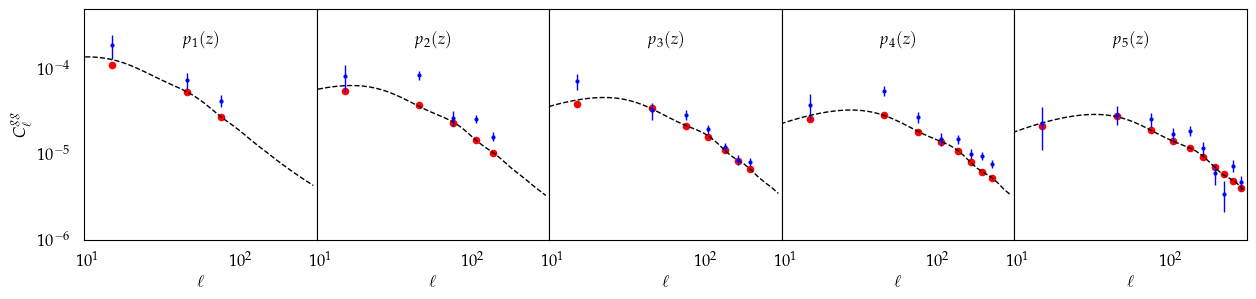

In [42]:
nx = 5 
ylims = (1E-6, 5E-4)
fontsize = 12
ylabel = r'$C_{\ell}^{gg}$'
xlabel = r'$\ell$'

f, ax = plt.subplots(1, nx, sharex=True, sharey = True, figsize = (15, 3))

for counter in range(nx):

    tracername = f'DESgc__{counter}'
    ell, c_ell, covariance, indices = saccfile_cut.get_ell_cl('cl_00', tracername, tracername, return_cov=True, return_ind=True)
    sigma = np.sqrt(np.diag(covariance))
    labz = f'$p_{counter+1}(z)$'
    key = f'{tracername},{tracername}'

    ax[counter].errorbar(ell, c_ell, sigma, fmt='bo', ms=2, lw =1)
    ax[counter].scatter(ell, bandpowers_gc[key], s = 20, c = 'r')
    ax[counter].plot(ell_grid_gc, cls_gc[counter], lw = 1, c = 'k', linestyle = '--')
    ax[counter].set_xlabel(xlabel, fontsize=fontsize)
    ax[counter].set_xlim(min(ell)-5, max(ell)+25)
    ax[counter].set_ylim(ylims[0], ylims[1])
    ax[counter].set_xscale("log")
    ax[counter].set_yscale("log")
    ax[counter].tick_params(axis = 'both', labelsize = fontsize, pad=10)
    ax[counter].tick_params(axis='both', which='both', length=0)
    ax[counter].annotate(labz, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=fontsize, horizontalalignment='center')
    if counter==0 :
        ax[counter].set_ylabel(ylabel, fontsize=fontsize)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Bandpowers for Weak Lensing

In [43]:
def wl_bandpower_calculation(cosmology, deltaz, nz_wl, a_ia_param, eta_param, multiplicative, record_band, tracer_combinations, ellmax=3000, nell = 30):
    
    # apply all the systematics here (shifts, multiplicative bias, intrinsic alignment)
    nz_wl_sys = [jc.redshift.systematic_shift(nzi, dzi) for nzi, dzi in zip(nz_wl, deltaz)]
    b_ia = jc.bias.des_y1_ia_bias(a_ia_param, eta_param, 0.62)
    probes_wl = [jc.probes.WeakLensing(nz_wl_sys, ia_bias=b_ia, multiplicative_bias=multiplicative)]
    
    # calculate the coarse power spectra for weak lensing
    ells_coarse = jnp.geomspace(2, ellmax, nell, dtype=jnp.float32)
    idx_pairs_wl = get_index_pairs(tracer_combinations, 'wl', 'wl')
    ps_wl = jc.angular_cl.angular_cl(cosmology, ells_coarse, probes_wl, index_pairs = idx_pairs_wl)

    # list to record the band powers
    recordbandpowers = dict()
    nbin_wl = len(nz_wl)
    
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
            
            # tracer names and data types
            tracername_wl_i = f'DESwl__{i}'
            tracername_wl_j = f'DESwl__{j}'
            key = f'{tracername_wl_i},{tracername_wl_j}'
            
            # build the interpolated cls 
            cls_gc_interp = interpolate(ells_coarse, ps_wl[i], record_band[key]['ells'])

            # calculate binned cls 
            recordbandpowers[key] = record_band[key]['bandwindow'].T @ cls_gc_interp
 
    return recordbandpowers  

In [44]:
bandpowers_wl = wl_bandpower_calculation(cosmo, deltaz, jax_nz_wl, a_ia_param,
                                         eta_param, multiplicative, record_band, tracer_combinations)

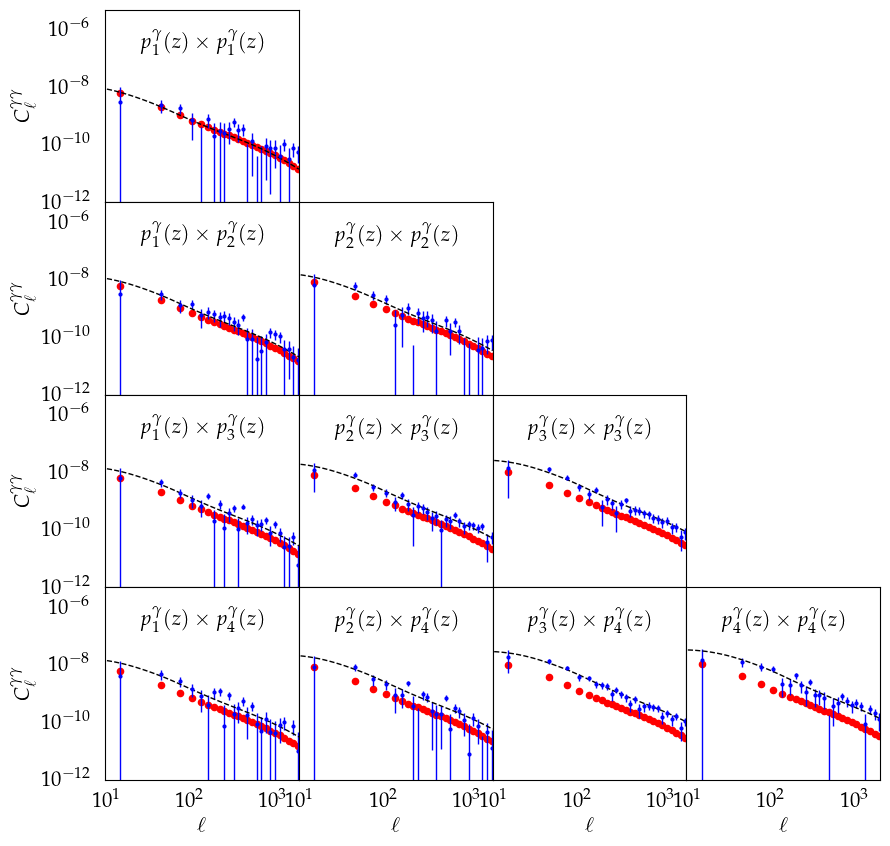

In [45]:
yLabel = r'$C_{\ell}^{\gamma\gamma}$'
xLabel = r'$\ell$'
ylims = [1E-12, 5E-6]
fontsize = fontSize

counter = 0

f, ax = plt.subplots(nbin_wl, nbin_wl, sharex=True, sharey = True, figsize = (10, 10))

for i in range(nbin_wl):
    for j in range(i, nbin_wl):

        labz = r'$p_{'+str(i+1)+'}^{\gamma}(z)\\times p_{'+str(j+1)+'}^{\gamma}(z)$'
        
        tracername_wl_i = f'DESwl__{i}'
        tracername_wl_j = f'DESwl__{j}'
        key = f'{tracername_wl_i},{tracername_wl_j}'
        
        ell, c_ell, covariance, indices = saccfile_cut.get_ell_cl('cl_ee', tracername_wl_i, tracername_wl_j, return_cov=True, return_ind=True)
        sigma = np.sqrt(np.diag(covariance))

        ax[j,i].errorbar(ell, c_ell, sigma, fmt='bo', ms=2, lw =1)
        ax[j,i].scatter(ell, bandpowers_wl[key], s = 20, c = 'r')
        ax[j,i].plot(ell_grid_wl, cls_wl[counter], lw = 1, c = 'k', linestyle = '--')
        ax[j,i].set_xlabel(xLabel, fontsize=fontsize)
        ax[j,i].set_xlim(min(ell)-5, max(ell)+50)
        ax[j,i].set_ylim(ylims[0], ylims[1])
        ax[j,i].set_xscale("log")
        ax[j,i].set_yscale("log")
        ax[j,i].axhline(0, linestyle='--', c = 'k', lw = 0.5)
        ax[j,i].tick_params(axis = 'both', labelsize = fontsize, pad=10)
        ax[j,i].tick_params(axis='both', which='both', length=0)
        ax[j,i].annotate(labz, xy=(0.5, 0.80), xycoords='axes fraction', fontsize=fontsize, horizontalalignment='center')

        if i==0 :
            ax[j, i].set_ylabel(yLabel, fontsize=fontsize)

        if j!=i:
            ax[i,j].axis('off')
            
        counter += 1

f.subplots_adjust(wspace=0)
f.subplots_adjust(hspace=0)
plt.show()

# Bandpowers for Galaxy Clustering and Shear

In [46]:
def gc_wl_bandpower_calculation(cosmology, deltaz, nz_wl, nz_gc, a_ia_param, eta_param, 
                                galaxybias, multiplicative, record_band, tracer_combinations, ellmax=3000, nell = 30):
    
    # apply all the systematics here (shifts, multiplicative bias, intrinsic alignment)
    nz_wl_sys = [jc.redshift.systematic_shift(nzi, dzi) for nzi, dzi in zip(jax_nz_wl, deltaz)]
    gc_biases = [jc.bias.constant_linear_bias(bi) for bi in galaxybias] 
    b_ia = jc.bias.des_y1_ia_bias(a_ia_param, eta_param, 0.62)

    probes_gc = [jc.probes.NumberCounts(nz_gc, gc_biases)]
    probes_wl = [jc.probes.WeakLensing(nz_wl_sys, ia_bias=b_ia, multiplicative_bias=multiplicative)]
    probes_gc_wl = probes_gc + probes_wl
    
    # calculate the coarse power spectra for weak lensing
    ells_coarse = jnp.geomspace(2, ellmax, nell).astype(int).astype(float)
    idx_pairs_gc_wl = get_index_pairs(tracer_combinations, 'gc', 'wl')
    ps_gc_wl = jc.angular_cl.angular_cl(cosmology, ells_coarse, probes_gc_wl, index_pairs = idx_pairs_gc_wl)

    # list to record the band powers
    recordbandpowers = dict()
    nbin_gc = len(nz_gc)
    nbin_wl = len(nz_wl)

    for i in range(nbin_gc):
        for j in range(nbin_wl):
            
            # tracer names and data types
            tracer_name_1 = f'DESgc__{i}'
            tracer_name_2 = f'DESwl__{j}'
            key = f'{tracer_name_1},{tracer_name_2}'
            
            # build the interpolated cls 
            cls_gc_interp = interpolate(ells_coarse, ps_gc_wl[i], record_band[key]['ells'])

            # calculate binned cls 
            recordbandpowers[key] = record_band[key]['bandwindow'].T @ cls_gc_interp
 
    return recordbandpowers  

In [47]:
bandpowers_gc_wl = gc_wl_bandpower_calculation(cosmo, deltaz, jax_nz_wl, jax_nz_gc, a_ia_param, eta_param, 
                                bias, multiplicative, record_band, tracer_combinations)

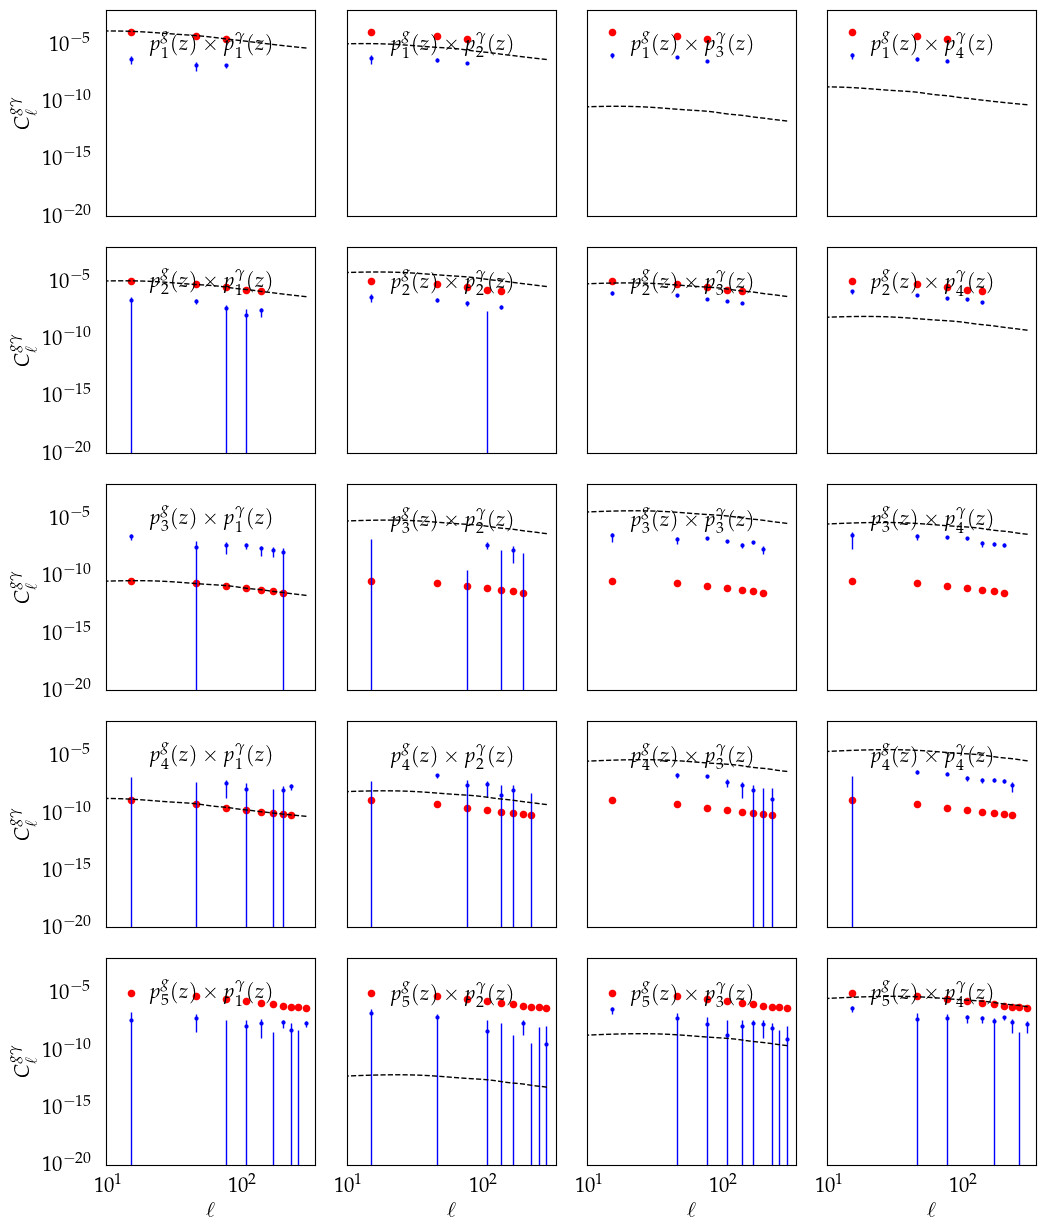

In [48]:
yLabel = r'$C_{\ell}^{g\gamma}$'
xLabel = r'$\ell$'
ylims = [1E-20, 1E-2]
fontsize = fontSize

f, ax = plt.subplots(nbin_gc, nbin_wl, sharex=True, sharey = True, figsize = (12, 15))
counter = 0
for i in range(nbin_gc):
    for j in range(nbin_wl):

        labz = r'$p_{'+str(i+1)+'}^{g}(z)\\times p_{'+str(j+1)+'}^{\gamma}(z)$'
        
        tracername_gc = f'DESgc__{i}'
        tracername_wl = f'DESwl__{j}'
        key = f'{tracername_gc},{tracername_wl}'
        
        ell, c_ell, covariance, indices = saccfile_cut.get_ell_cl('cl_0e', tracername_gc, tracername_wl, return_cov=True, return_ind=True)
        sigma = np.sqrt(np.diag(covariance))

        ax[i,j].errorbar(ell, c_ell, sigma, fmt='bo', ms=2, lw =1)
        ax[i,j].scatter(ell, bandpowers_gc_wl[key], s = 20, c = 'r')
        ax[i,j].plot(ell_grid_gc, cls_gc_wl[counter], lw = 1, c = 'k', linestyle = '--')
        ax[i,j].set_xlim(min(ell)-5, max(ell)+50)
        ax[i,j].set_ylim(ylims[0], ylims[1])
        ax[i,j].set_xscale("log")
        ax[i,j].set_yscale("log")
        ax[i,j].axhline(0, linestyle='--', c = 'k', lw = 0.5)
        ax[i,j].tick_params(axis = 'both', labelsize = fontsize, pad=10)
        ax[i,j].tick_params(axis='both', which='both', length=0)
        ax[i,j].annotate(labz, xy=(0.5, 0.80), xycoords='axes fraction', fontsize=fontsize, horizontalalignment='center')

        if j==0 :
            ax[i,j].set_ylabel(yLabel, fontsize=fontsize)
        if i==nbin_gc-1:
            ax[i,j].set_xlabel(xLabel, fontsize=fontsize)
            
        counter += 1

f.subplots_adjust(wspace=0.15)
f.subplots_adjust(hspace=0.15)
plt.show()

# Get the Full Theory Vector

In [49]:
def extract_theory(gc_bandpowers, gc_wl_bandpowers, wl_bandpowers, tracers):
    ntracers = len(tracers)
    nbin_gc = sum(['DESgc__' in tracers[i] for i in range(ntracers)])
    nbin_wl = sum(['DESwl__' in tracers[i] for i in range(ntracers)])
    
    theory = list()
    # galaxy-galaxy
    for i in range(nbin_gc):
        tracer_name = f'DESgc__{i}'
        key = f'{tracer_name},{tracer_name}'
        theory.append(gc_bandpowers[key])

    # galaxy-shear
    for i in range(nbin_gc):
        for j in range(nbin_wl):
            tracer_name_1 = f'DESgc__{i}'
            tracer_name_2 = f'DESwl__{j}'
            key = f'{tracer_name_1},{tracer_name_2}'
            theory.append(gc_wl_bandpowers[key])

    # shear-shear
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
            tracer_name_1 = f'DESwl__{i}'
            tracer_name_2 = f'DESwl__{j}'
            key = f'{tracer_name_1},{tracer_name_2}'
            theory.append(wl_bandpowers[key])
    return jnp.concatenate(theory)

# Likelihood Computation

In [50]:
data = jnp.asarray(data)
invcov = jnp.linalg.inv(jnp.asarray(datacov))

NZ_WL = jax_nz_wl
NZ_GC = jax_nz_gc
BANDWINDOW = record_band
TRACERS_COMB = tracer_combinations
TRACERS = tracers
ELLMAX = 3000
NELL = 30

## Negative log-likelihood

In this case, calculate the theory first, followed by the log-likelihood calculation.

NOTE: it seems that the first run takes some time (maybe it's the compiling process).

In [51]:
def theory_calculation(parameters):
    # follow cosmo jax notation 
    cosmo, multiplicative, deltaz, (a_ia_param, eta_param), bias = unpack_params_vec(parameters) 
    
    # calculate all the band powers 
    bandpowers_gc = gc_bandpower_calculation(cosmo, bias, NZ_GC, BANDWINDOW, TRACERS_COMB, ELLMAX, NELL)
    
    bandpowers_gc_wl = gc_wl_bandpower_calculation(cosmo, deltaz, NZ_WL, NZ_GC, a_ia_param, eta_param, 
                                    bias, multiplicative, BANDWINDOW, TRACERS_COMB, ELLMAX, NELL)
    
    bandpowers_wl = wl_bandpower_calculation(cosmo, deltaz, NZ_WL, a_ia_param, eta_param, 
                                             multiplicative, BANDWINDOW, TRACERS_COMB, ELLMAX, NELL)

    theory = extract_theory(bandpowers_gc, bandpowers_gc_wl, bandpowers_wl, tracers)
    return theory

In [52]:
def negative_loglikelihood_theory(theory, data, invcov):
    
    # calculate the negative log-likelihood
    diff = data - theory 
    nll = 0.5 * diff @ invcov @ diff 
    return nll 

In [57]:
theory_jit = jit(theory_calculation)
theory_jacobian_jit = jit(jacfwd(lambda p: theory_calculation(p)))

In [58]:
%%time
theory_values = theory_jit(params).block_until_ready()

CPU times: user 25.6 s, sys: 320 ms, total: 25.9 s
Wall time: 25.2 s


In [59]:
%%time
theory_values = theory_jit(params).block_until_ready()

CPU times: user 143 ms, sys: 13.6 ms, total: 157 ms
Wall time: 83.6 ms


In [60]:
%%time
grad_theory = theory_jacobian_jit(params).block_until_ready()

CPU times: user 1min 33s, sys: 660 ms, total: 1min 34s
Wall time: 1min 31s


In [61]:
%%time
grad_theory = theory_jacobian_jit(params).block_until_ready()

CPU times: user 1.85 s, sys: 302 ms, total: 2.15 s
Wall time: 727 ms


In [62]:
negative_loglikelihood_theory(theory_values, data, invcov)

Array(1363392.2, dtype=float32)

# Negative log-likelihood

If we use the parameters, data and inverse-covariance in the calculation of the $-\mathcal{L}$.

In [63]:
def negative_loglikelihood_param(param, data, invcov):
    # follow cosmo jax notation 
    cosmo, multiplicative, deltaz, (a_ia_param, eta_param), bias = unpack_params_vec(param) 
    
    # calculate all the band powers 
    bandpowers_gc = gc_bandpower_calculation(cosmo, bias, NZ_GC, BANDWINDOW, TRACERS_COMB, ELLMAX, NELL)
    
    bandpowers_gc_wl = gc_wl_bandpower_calculation(cosmo, deltaz, NZ_WL, NZ_GC, a_ia_param, eta_param, 
                                    bias, multiplicative, BANDWINDOW, TRACERS_COMB, ELLMAX, NELL)
    
    bandpowers_wl = wl_bandpower_calculation(cosmo, deltaz, NZ_WL, a_ia_param, eta_param, 
                                             multiplicative, BANDWINDOW, TRACERS_COMB, ELLMAX, NELL)

    theory = extract_theory(bandpowers_gc, bandpowers_gc_wl, bandpowers_wl, tracers)

    # calculate the negative log-likelihood
    diff = data - theory 
    nll = 0.5 * diff @ invcov @ diff 
    return nll 

In [65]:
nll_jit = jit(negative_loglikelihood_param)
nll_jacobian_jit = jit(jacfwd(negative_loglikelihood_param))

In [66]:
%%time
value_nll = nll_jit(params, data, invcov).block_until_ready()

CPU times: user 25.8 s, sys: 93.3 ms, total: 25.9 s
Wall time: 25.1 s


In [67]:
%%time
value_nll = nll_jit(params, data, invcov).block_until_ready()

CPU times: user 148 ms, sys: 0 ns, total: 148 ms
Wall time: 77 ms


In [68]:
%%time
grad_nll = nll_jacobian_jit(params, data, invcov).block_until_ready()

CPU times: user 1min 31s, sys: 636 ms, total: 1min 32s
Wall time: 1min 29s


This is just a test that it is very fast if we modify the input parameter.

In [69]:
%%time
grad_nll = nll_jacobian_jit(params+1E-6, data, invcov).block_until_ready()

CPU times: user 1.84 s, sys: 385 ms, total: 2.22 s
Wall time: 730 ms


In [70]:
value_nll

Array(1363392.2, dtype=float32)